In [1]:
# Initialize the notebook
using Pkg
Pkg.activate("..")
#include("../src/Particles.jl")
using Particles
using Plots
using Zarr
using ZipFile

nothing

  Activating project at `~/verlaan_shared/src/julia/Particles2`


In [2]:
# unzip the test data

# function unzip(file,exdir="")
# extract all files from zip file to exdir
function unzip(file,exdir="")
    fileFullPath = isabspath(file) ?  file : joinpath(pwd(),file)
    basePath = dirname(fileFullPath)
    outPath = (exdir == "" ? basePath : (isabspath(exdir) ? exdir : joinpath(pwd(),exdir)))
    isdir(outPath) ? "" : mkdir(outPath)    
    zarchive = ZipFile.Reader(fileFullPath)
    for f in zarchive.files
        fullFilePath = joinpath(outPath,f.name)
        if (endswith(f.name,"/") || endswith(f.name,"\\"))
            mkdir(fullFilePath)
        else
            write(fullFilePath, read(f))
        end
    end
    close(zarchive)
end

unzip("./data/tidal_flume_map.zip","./data")

In [3]:
Zarr_data = ZarrData("./data","tidal_flume_map.zarr")
t0=get_reftime(Zarr_data)
h=initialize_interpolation(Zarr_data,"waterlevel",t0)
u=initialize_interpolation(Zarr_data,"x_velocity",t0)
w=initialize_interpolation(Zarr_data,"z_velocity",t0)
s=initialize_interpolation(Zarr_data,"salinity",t0)
nu=initialize_interpolation(Zarr_data,"eddy_visc_z",t0)

nothing

In [4]:
s_temp=Zarr_data.file["z_iface_3d"][10,1,:,700]
@show s_temp
@show Zarr_data.file["z_iface_3d"].attrs

s_temp = Int16[-200, -190, -180, -170, -160, -150, -140, -130, -120, -110, -100, -90, -80, -70, -60, -50, -40, -31, -21, -12, -2]
(Zarr_data.file["z_iface_3d"]).attrs = 

Dict{String, Any}("cell_methods" => "mesh2d_nFaces: mean", "long_name" => "Vertical coordinate of layer interfaces at pressure points", "scale_factor" => 0.001, "location" => "face", "add_offset" => 0.0, "standard_name" => "altitude", "coordinates" => "time z_iface_3d y_center x_center", "cell_measures" => "area: mesh2d_flowelem_ba", "mesh" => "mesh2d", "_FillValue" => -9999.0, "units" => "m", "_ARRAY_DIMENSIONS" => Any["time", "z_iface", "y", "x"], "grid_mapping" => "projected_coordinate_system")


Dict{String, Any} with 13 entries:
  "cell_methods"      => "mesh2d_nFaces: mean"
  "long_name"         => "Vertical coordinate of layer interfaces at pressure p…
  "scale_factor"      => 0.001
  "location"          => "face"
  "add_offset"        => 0.0
  "standard_name"     => "altitude"
  "coordinates"       => "time z_iface_3d y_center x_center"
  "cell_measures"     => "area: mesh2d_flowelem_ba"
  "mesh"              => "mesh2d"
  "_FillValue"        => -9999.0
  "units"             => "m"
  "_ARRAY_DIMENSIONS" => Any["time", "z_iface", "y", "x"]
  "grid_mapping"      => "projected_coordinate_system"

In [5]:
# find the extent of the data
xy_bbox=Zarr_data.xy_grid.bbox
z=Zarr_data.z_iface
minz = minimum(z) #scaled
#maxx = maximum(x)
#minx,
#z[1,1,:,1]
#size(z)
@show minz

minz = -9999


-9999

t=1200.0 t=2400.0 

t=3600.0 t=4800.0 

┌ Info: Saved animation to /home/verlaan/verlaan_shared/src/julia/Particles2/case_tidal_flume/tidal_flume.gif
└ @ Plots /home/verlaan/.julia/packages/Plots/QWCV6/src/animation.jl:156


Plots.AnimatedGif("/home/verlaan/verlaan_shared/src/julia/Particles2/case_tidal_flume/tidal_flume.gif")
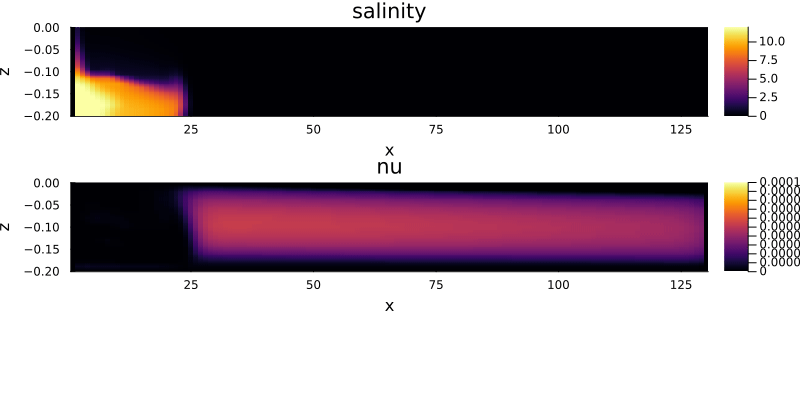

In [7]:
x_left = 1.0
x_right = 130.0
y_middle = 1.0
z_surface = 0.0
z_bottom = -0.2
t_start=1200.0
t_step=60.0
t_stop=5999.0 #max 100minutes=6000s with steps 6s / period is 600s


anim = @animate for t in range(t_start, stop = t_stop, step = t_step)
    if t%1200==0 print("t=$(t) ") end
    # grid for plotting only
    x_points = range(x_left,stop=x_right,length=130)
    z_points = range(z_bottom,stop=z_surface,length=100)
    u_interp = [u(x,y_middle,z,t) for x in x_points, z in z_points] # x velocity
    w_interp = [w(x,y_middle,z,t) for x in x_points, z in z_points] # z velocity
    s_interp = [s(x,y_middle,z,t) for x in x_points, z in z_points] # salinity
    nu_interp = [nu(x,y_middle,z,t) for x in x_points, z in z_points] # nu

    l = @layout([a; b; c])
    #p1=heatmap(x_points,z_points,u_interp',xlabel="x",ylabel="z",title="u velocity time=$(t)",clims=(-0.5,0.5))
    p2=heatmap(x_points,z_points,s_interp',xlabel="x",ylabel="z",title="salinity",clims=(0,12))
    p3=heatmap(x_points,z_points,nu_interp',xlabel="x",ylabel="z",title="nu",clims=(0,0.0001))
    plot(p2,p3,layout=l,size=(800,400))
end

gif(anim, "./tidal_flume.gif", fps = 3)
